In [50]:
import os
import glob
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sn

import PIL
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torchinfo import summary

import torch.optim as optim
from IPython.display import Image
from torch.utils.data import DataLoader, Dataset
# from galaxy_mnist import GalaxyMNIST

from torchvision.datasets import ImageFolder

import torch.nn.functional as TF

from torchvision.transforms import transforms
from torch.utils.data import TensorDataset

import cv2
import torchvision.models as models

In [51]:
# Use GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [52]:
%pip install git+https://github.com/mwalmsley/galaxy_mnist.git
from galaxy_mnist import GalaxyMNIST
from galaxy_mnist import GalaxyMNISTHighrez


  Cloning https://github.com/mwalmsley/galaxy_mnist.git to /tmp/pip-req-build-v98gghs2
  Running command git clone --filter=blob:none --quiet https://github.com/mwalmsley/galaxy_mnist.git /tmp/pip-req-build-v98gghs2
  Resolved https://github.com/mwalmsley/galaxy_mnist.git to commit 375e0257bfd41acbcb7ba2e0f33c8c04d0d5beef
  Preparing metadata (setup.py) ... done
Note: you may need to restart the kernel to use updated packages.


In [53]:
#  Import galaxyMNIST dataset
tv_dataset = GalaxyMNISTHighrez(
    root='ML_DP/gal_mnist',
    download=True,
    train=True  # by default, or False for canonical test set
)

test_dataset = GalaxyMNISTHighrez(
    root='ML_DP/gal_mnist',
    download=True,
    train=False  # by default, or False for canonical test set
)

tv_images = tv_dataset.data
tv_labels = tv_dataset.targets

test_images = test_dataset.data
test_labels = test_dataset.targets


# Split in test, validation, train
# images_tv, images_test, y_tv, y_test  = train_test_split(images, labels, shuffle=True, test_size=0.2, random_state=123)
images_train, images_val, y_train, y_val  = train_test_split(tv_images, tv_labels, shuffle=True, test_size=0.25, random_state=123)

# Create PyTorch dataset
train_dataset = TensorDataset(images_train, y_train)
val_dataset = TensorDataset(images_val, y_val)
test_dataset = TensorDataset(test_images, test_labels)

100%|██████████| 900487097/900487097 [00:55<00:00, 16358470.88it/s]


Extracting ML_DP/gal_mnist/GalaxyMNISTHighrez/raw/train_dataset.hdf5.gz to ML_DP/gal_mnist/GalaxyMNISTHighrez/raw


100%|██████████| 225656501/225656501 [00:09<00:00, 24017397.10it/s]


Extracting ML_DP/gal_mnist/GalaxyMNISTHighrez/raw/test_dataset.hdf5.gz to ML_DP/gal_mnist/GalaxyMNISTHighrez/raw


In [54]:
VGG_model = models.resnet50(pretrained=True)

for param in VGG_model.parameters():
        param.requires_grad = False

    # define out classifier
classifier = nn.Sequential(
   nn.Linear(in_features=2048, out_features=512),
   nn.ReLU(),
   nn.Linear(in_features=512, out_features=256),
   nn.ReLU(),
   nn.Linear(in_features=256, out_features=4)
)

# replace model class classifier attribute:
VGG_model.fc = classifier
# print(VGG_model)

# define training function

def train_model(model, train_dataset, val_dataset, test_dataset, device,
                lr=0.0001, epochs=30, batch_size=32, l2=0.00001, gamma=0.5,
                patience=5, freezed_epochs = 15):
    model = model.to(device)

    # construct dataloader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

    # history
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    # set up loss function and optimizer
    criterion = nn.CrossEntropyLoss()
#     optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001, momentum=0.9)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=l2
                                 , momentum = 0.9 )  # pass in the parameters to be updated and learning rate
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=patience, gamma=gamma)
    
    lear_rate = []
    

    # Training Loop
    print("Training Start:")
    for epoch in range(freezed_epochs):
        model.train()  # start to train the model, activate training behavior

        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0

        for i, (images, labels) in enumerate(train_loader):
            # reshape images
            images = images.to(device)
            images = images.float()# reshape: from (128, 1, 28, 28) -> (128, 28 * 28) = (128, 284), move batch to device
            labels = labels.to(device)  # move to device
            # forward
            outputs = model(images)  # forward
#             outputs = TF.softmax(outputs, dim=1)
            _, pred = torch.max(outputs.data, 1)

            cur_train_loss = criterion(outputs, labels)  # loss
            cur_train_acc = (pred == labels).sum().item() / batch_size

            # backward
            optimizer.zero_grad()       # set gradient to zero, avoid gradient accumulating
            
            cur_train_loss.backward()   # run back propagation
            optimizer.step()            # optimizer update all model parameters

            # loss
            train_loss += cur_train_loss
            train_acc += cur_train_acc

        # valid
        model.eval()  # start to train the model, activate training behavior
        with torch.no_grad():  # tell pytorch not to update parameters
            for images, labels in val_loader:
                # calculate validation loss
                images = images.to(device)
                labels = labels.to(device)
                images = images.float()
                
                outputs = model(images)
#                 outputs = TF.softmax(outputs, dim=1)

                # loss
                cur_valid_loss = criterion(outputs, labels)
                val_loss += cur_valid_loss
                # acc
                _, pred = torch.max(outputs.data, 1)
               
                val_acc += (pred == labels).sum().item() / batch_size

        # learning schedule step
        scheduler.step()

        # print training feedback
        train_loss = train_loss / len(train_loader)
        train_acc = train_acc / len(train_loader)
        val_loss = val_loss / len(val_loader)
        val_acc = val_acc / len(val_loader)

        print(f"Epoch:{epoch + 1} / {epochs}, lr: {optimizer.param_groups[0]['lr']:.5f} train loss:{train_loss:.5f}, train acc: {train_acc:.5f}, valid loss:{val_loss:.5f}, valid acc:{val_acc:.5f}")

        # update history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        lear_rate.append(scheduler.get_last_lr())
        
        
    for param in model.parameters():
        param.requires_grad = True

    # Training Loop
    print("De-freezed:")
    for epoch in range(epochs-freezed_epochs):
        model.train()  # start to train the model, activate training behavior

        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0

        for i, (images, labels) in enumerate(train_loader):
            # reshape images
            images = images.to(device)
            images = images.float()# reshape: from (128, 1, 28, 28) -> (128, 28 * 28) = (128, 284), move batch to device
            labels = labels.to(device)  # move to device
            # forward
            outputs = model(images)  # forward
#             outputs = TF.softmax(outputs, dim=1)
            _, pred = torch.max(outputs.data, 1)

            cur_train_loss = criterion(outputs, labels)  # loss
            cur_train_acc = (pred == labels).sum().item() / batch_size

            # backward
            cur_train_loss.backward()   # run back propagation
            optimizer.step()            # optimizer update all model parameters
            optimizer.zero_grad()       # set gradient to zero, avoid gradient accumulating

            # loss
            train_loss += cur_train_loss
            train_acc += cur_train_acc

        # valid
        model.eval()  # start to train the model, activate training behavior
        with torch.no_grad():  # tell pytorch not to update parameters
            for images, labels in val_loader:
                # calculate validation loss
                images = images.to(device)
                labels = labels.to(device)
                images = images.float()
                
                outputs = model(images)
#                 outputs = TF.softmax(outputs, dim=1)

                # loss
                cur_valid_loss = criterion(outputs, labels)
                val_loss += cur_valid_loss
                # acc
                _, pred = torch.max(outputs.data, 1)
               
                val_acc += (pred == labels).sum().item() / batch_size

        # learning schedule step
        scheduler.step()

        # print training feedback
        train_loss = train_loss / len(train_loader)
        train_acc = train_acc / len(train_loader)
        val_loss = val_loss / len(val_loader)
        val_acc = val_acc / len(val_loader)

        print(f"Epoch:{epoch + freezed_epochs + 1} / {epochs}, lr: {optimizer.param_groups[0]['lr']:.5f} train loss:{train_loss:.5f}, train acc: {train_acc:.5f}, valid loss:{val_loss:.5f}, valid acc:{val_acc:.5f}")

        # update history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        lear_rate.append(scheduler.get_last_lr())
        
        
    test_acc = 0
    
    lab_true = []
    lab_pred = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            images = images.float()
            # calculate outputs by running images through the network
            outputs = model(images)
            # the class with the highest energy is what we choose as prediction
            _, pred = torch.max(outputs.data, 1)
            test_acc += (pred == labels).sum().item()
            
            lab_pred.extend(pred.cpu().numpy())
            labels = labels.data.cpu().numpy()
            lab_true.extend(labels)
    print(f'Test Accuracy:  {(test_acc / len(test_loader))}')
    
    
    
    return history, lab_true, lab_pred, lear_rate

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [55]:
# Train the CNN model
hist, lab_true, lab_pred, lr = train_model(VGG_model, train_dataset, val_dataset, test_dataset, device, lr=0.01, batch_size=32, epochs=30, l2=0.0001
                   , patience=5)

Training Start:
Epoch:1 / 30, lr: 0.01000 train loss:0.90713, train acc: 0.60173, valid loss:0.72332, valid acc:0.70188
Epoch:2 / 30, lr: 0.01000 train loss:0.66457, train acc: 0.71659, valid loss:0.60964, valid acc:0.74603
Epoch:3 / 30, lr: 0.01000 train loss:0.61997, train acc: 0.73554, valid loss:0.66530, valid acc:0.71181
Epoch:4 / 30, lr: 0.01000 train loss:0.63521, train acc: 0.73022, valid loss:0.60147, valid acc:0.74157
Epoch:5 / 30, lr: 0.00500 train loss:0.59835, train acc: 0.75283, valid loss:0.67835, valid acc:0.69643
Epoch:6 / 30, lr: 0.00500 train loss:0.52974, train acc: 0.77460, valid loss:0.53660, valid acc:0.76935
Epoch:7 / 30, lr: 0.00500 train loss:0.53045, train acc: 0.77643, valid loss:0.53763, valid acc:0.77679
Epoch:8 / 30, lr: 0.00500 train loss:0.51702, train acc: 0.77626, valid loss:0.53306, valid acc:0.78125
Epoch:9 / 30, lr: 0.00500 train loss:0.51705, train acc: 0.78092, valid loss:0.54037, valid acc:0.76935
Epoch:10 / 30, lr: 0.00250 train loss:0.51156, t

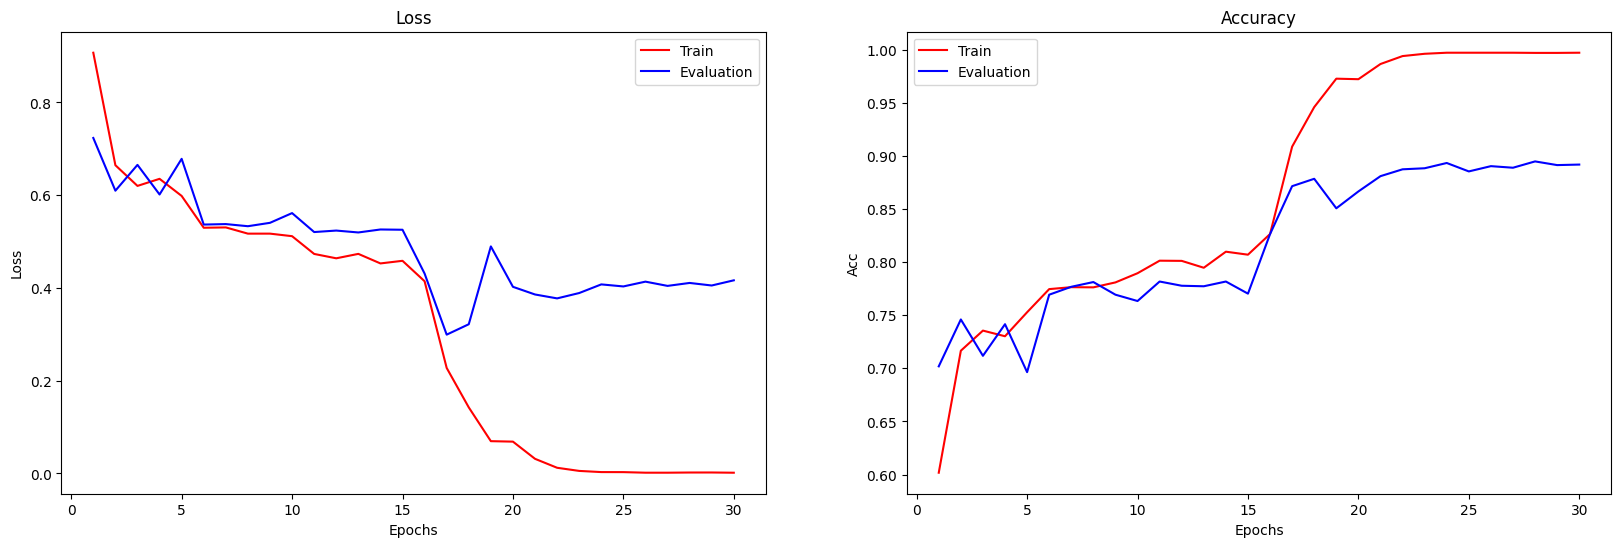

In [59]:
train_loss = torch.tensor(hist['train_loss'])
val_loss = torch.tensor(hist['val_loss'])
train_acc = torch.tensor(hist['train_acc'])
val_acc =  torch.tensor(hist['val_acc'])



# plot training curves
epochs = range(1, len(hist['train_loss']) + 1)

fig, ax = plt.subplots(1,2, figsize=(20,6))
ax[0].plot(epochs, train_loss, 'r-', label='Train')
ax[0].plot(epochs, val_loss , 'b-', label='Evaluation')
ax[0].set_title('Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()


ax[1].plot(epochs, train_acc, 'r-', label='Train')
ax[1].plot(epochs, val_acc , 'b-', label='Evaluation')
ax[1].set_title('Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Acc')
ax[1].legend()

plt.show()

<Axes: >

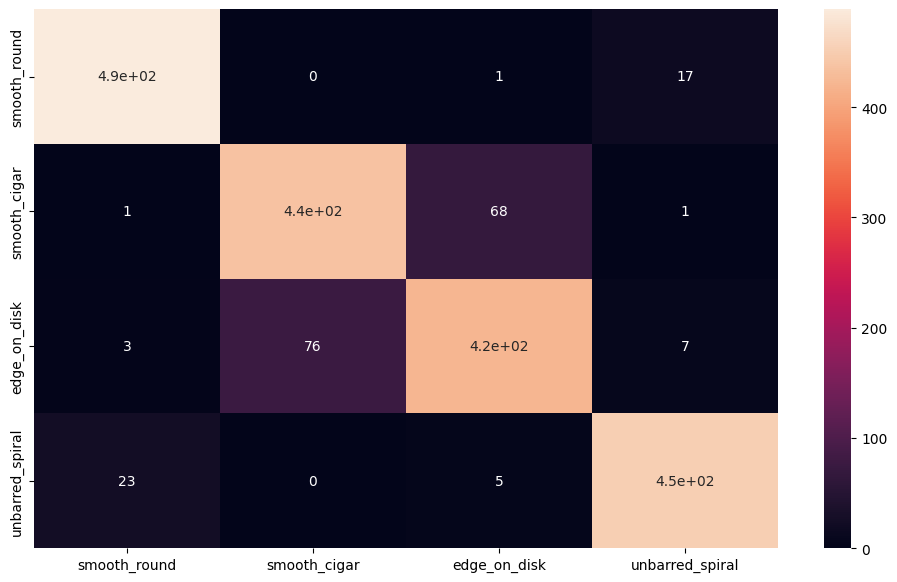

In [60]:
import pandas as pd
cf_matrix = confusion_matrix(lab_true, lab_pred)
classes = GalaxyMNIST.classes
df_cm = pd.DataFrame(cf_matrix 
                     , index = [i for i in classes], columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)

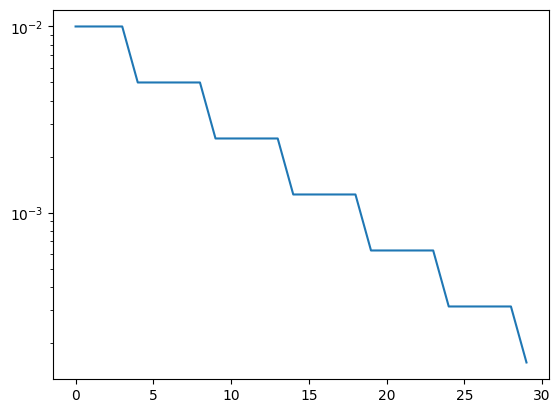

In [58]:
plt.plot(lr)
plt.yscale('log')